In [1]:
CONSTRAINT_TOOLS = '/scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools'
CONSTRAINT_TOOLS_DATA = '/scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools'

import sys
sys.path.append(f'{CONSTRAINT_TOOLS}/utilities')

## Assign scores to non-exonic Chen windows 

In [2]:
import pandas as pd
import numpy as np

from shell import shell 
from colorize import print_string_as_info
from aggregate import aggregate

def get_chen_windows_with_enhancers_exons():
  # the following bed file was produced by experiments/germline-model/chen-et-al-2022/Fig_2a.Nonly.noisy.ipynb
  filename = f'{CONSTRAINT_TOOLS_DATA}/benchmark-genome-wide-predictions/chen-et-al-2022/mchale.kmerSizes.trainSets.noisy.enhancer-exon.bed'
  df = pd.read_csv(filename, sep='\t')
  df = df[['chromosome', 'start', 'end', 'window overlaps enhancer', 'window overlaps merged_exon']]
  df = df.rename(columns={
    'chromosome': 'chrom'
  })
  return df

get_chen_windows_with_enhancers_exons()

,chrom,start,end,window overlaps enhancer,window overlaps merged_exon
0,chr1,1432000,1433000,True,False
1,chr1,1435000,1436000,True,True
2,chr1,1449000,1450000,False,True
3,chr1,1450000,1451000,False,True
4,chr1,1451000,1452000,False,False
...,...,...,...,...,...
1786072,chr9,137269000,137270000,True,False
1786073,chr9,137275000,137276000,True,False
1786074,chr9,137282000,137283000,True,True
1786075,chr9,137290000,137291000,False,False


In [3]:
def get_header(filename):
  with open(filename) as fh: 
    header = fh.readline().strip().split('\t')
  return header

def intersect(a_filename, b_filename, intersect_filename): 
  cmd = (
    f'bedtools intersect'
    f" -a <(tail -n +2 {a_filename})" # contains header
    f" -b <(cat {b_filename})"        # does not contain header
    f' -wao -f 0.5'
    f' > {intersect_filename}'
  )
  shell(cmd)
  print_string_as_info(f'Wrote {intersect_filename}')

  a_file_header = get_header(a_filename)               # contains header
  b_file_header = ['B_chrom', 'B_start', 'B_end', 'B'] # does not contain header

  return a_file_header, b_file_header

def set_column_dtypes(df, column_dtypes, log=False): 
  for col, dtype in column_dtypes.items(): 
    df[col] = df[col].astype(dtype)

  if log: print(dict(df.dtypes))
  return df 

def make_scores_numeric(df): 
  # we don't want to include enhancers that don't overlap any windows with B-values
  df = df[df['B_chrom'] != '.'] 

  # having removed records where 'B_chrom' is '.', we can now convert the 'B' column to a float
  df = set_column_dtypes(
    df,   
    column_dtypes = {
      'B': float,
    }
  )

  return df 
  
def assign_scores_to_chen_windows():
  df_gnocchi = pd.read_csv(
    f'{CONSTRAINT_TOOLS_DATA}/chen-et-al-2023-published-version/41586_2023_6045_MOESM4_ESM/Supplementary_Data_2-gnocchi.bed',
    sep='\t',
    names=['chrom', 'start', 'end', 'gnocchi']
  )
  df_N_expected = pd.read_csv(
    f'{CONSTRAINT_TOOLS_DATA}/chen-et-al-2023-published-version/41586_2023_6045_MOESM4_ESM/Supplementary_Data_2-N_expected_gnocchi.bed',
    sep='\t',
    names=['chrom', 'start', 'end', 'N_expected']
  )
  df_N_observed = pd.read_csv(
    f'{CONSTRAINT_TOOLS_DATA}/chen-et-al-2023-published-version/41586_2023_6045_MOESM4_ESM/Supplementary_Data_2-N_observed.bed',
    sep='\t',
    names=['chrom', 'start', 'end', 'N_observed']
  )
  df_enhancers_exons = get_chen_windows_with_enhancers_exons()

  df = pd.merge(
    df_gnocchi, 
    df_N_expected, 
    on=['chrom', 'start', 'end'],
    how='inner'
  )
  df = pd.merge(
    df, 
    df_N_observed, 
    on=['chrom', 'start', 'end'],
    how='inner'
  )
  df = pd.merge(
    df, 
    df_enhancers_exons, 
    on=['chrom', 'start', 'end'],
    how='inner'
  )

  # Chen et al windows: 
  a_filename = f'{CONSTRAINT_TOOLS_DATA}/chen-et-al-2023-published-version/41586_2023_6045_MOESM4_ESM/Supplementary_Data_2.gnocchi.N_expected.N_observed.bed' 
  df.to_csv(
    a_filename,
    sep='\t',
    index=False,
  )

  # assign B-values to Chen et al. windows 
  b_filename = f'{CONSTRAINT_TOOLS_DATA}/background-selection/CADD-B-map/bmap.hg38.bed' 
  intersect_filename = f'{CONSTRAINT_TOOLS_DATA}/chen-et-al-2023-published-version/41586_2023_6045_MOESM4_ESM/Supplementary_Data_2.gnocchi.N_expected.N_observed.intersect.bmap.bed'

  a_file_header, b_file_header = intersect(a_filename, b_filename, intersect_filename)

  df = pd.read_csv(
    intersect_filename, 
    sep='\t',
    names=a_file_header + b_file_header + ['chenWindow_BWindow_overlap'],
  )

  df = make_scores_numeric(df)

  # though unlikely, some Chen-windows may intersect multiple B-windows, 
  # so let's group by Chen-window, and aggregare scores over all B-windows in the group
  df = aggregate(
    df, 
    group_columns = a_file_header,
    aggregation_functions = {
      'B': [np.max],
    }
  )

  df = df.rename(columns={'max B': 'B'})

  df = df[df['window overlaps merged_exon'] == False] # strictly non-exonic windows

  return df

pd.set_option('display.max_columns', 100)

WINDOWS = assign_scores_to_chen_windows()
WINDOWS

Wrote /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/chen-et-al-2023-published-version/41586_2023_6045_MOESM4_ESM/Supplementary_Data_2.gnocchi.N_expected.N_observed.intersect.bmap.bed
<ipython-input-3-bc9ba8eafc0d>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].astype(dtype)


,chrom,start,end,gnocchi,N_expected,N_observed,window overlaps enhancer,window overlaps merged_exon,B
0,chr1,1432000,1433000,4.299894,338.059552,259,True,False,0.653
4,chr1,1451000,1452000,0.666316,302.590657,291,False,False,0.652
5,chr1,1453000,1454000,0.828398,269.601925,256,False,False,0.651
7,chr1,1458000,1459000,-0.086128,270.583243,272,False,False,0.651
11,chr1,1463000,1464000,2.948188,236.321790,191,True,False,0.651
...,...,...,...,...,...,...,...,...,...
1597322,chr9,137262000,137263000,-2.396149,263.131293,302,True,False,0.536
1597323,chr9,137268000,137269000,3.640544,272.046527,212,True,False,0.536
1597324,chr9,137269000,137270000,5.276351,300.458958,209,True,False,0.536
1597325,chr9,137275000,137276000,2.687348,339.517045,290,True,False,0.536


## For those non-exonic Chen windows subject to strong BGS, the model overestimates the observed SNV count more often than it underestimates it

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn.linear_model import LinearRegression

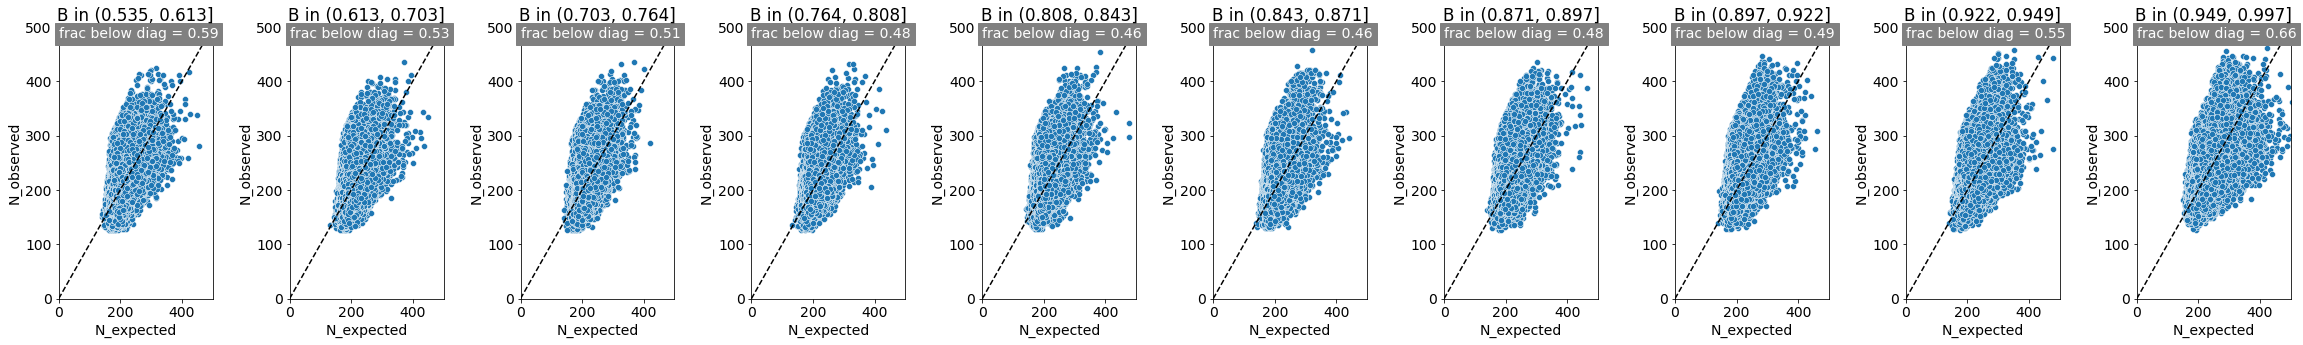

In [5]:
plt.rcParams.update({
  'font.size': 14,
})

def correlate_observed_counts_with_expected_counts(df, number_b_quantiles=10): 
  df = df.copy() 
  
  df['B_range'] = pd.qcut(df['B'], q=number_b_quantiles, labels=None, retbins=False)

  fig, axs = plt.subplots(1, number_b_quantiles, figsize=(40, 5))
  plt.subplots_adjust(wspace=0.5)
  for i, b_quantile in enumerate(sorted(df['B_range'].unique())): 
    df_b_range = df[df['B_range'] == b_quantile]
    sns.scatterplot(
      data=df_b_range, 
      x='N_expected', 
      y='N_observed', 
      ax=axs[i],
    )
    axs[i].plot([0, 500], [0, 500], color='black', linestyle='--')
    axs[i].set_title(f'B in {b_quantile}')

    # r = df_b_range['N_expected'].corr(df_b_range['N_observed'])
    # axs[i].text(50, 500, f'r = {r:.2f}', ha='left', va='top', backgroundcolor='grey', color='white')

    fraction_below_diagonal = (df_b_range['N_observed'] < df_b_range['N_expected']).sum() / len(df_b_range)
    axs[i].text(0, 500, f'frac below diag = {fraction_below_diagonal:.2f}', ha='left', va='top', backgroundcolor='grey', color='white')

    # gnocchi_threshold = 3
    # fraction_gnocchi = (df_b_range['gnocchi'] > gnocchi_threshold).sum() / len(df_b_range)
    # axs[i].text(0, 450, f'frac gnocchi > {gnocchi_threshold} = {fraction_gnocchi:.3f}', ha='left', va='top', backgroundcolor='grey', color='white')
  
    # x = df_b_range['N_expected']
    # y = df_b_range['N_observed']
    # model = LinearRegression()
    # model.fit(x.values.reshape(-1, 1), y)
    # slope = model.coef_[0]
    # intercept = model.intercept_
    # axs[i].text(50, 400, f'slope = {slope:.2f}', ha='left', va='top', backgroundcolor='grey', color='white')
    # xs = np.array([0, 500])
    # ys = slope * xs + intercept
    # axs[i].plot(xs, ys, color='red', linestyle='--')

    axs[i].set_xlim(0, 500)
    axs[i].set_ylim(0, 500)

correlate_observed_counts_with_expected_counts(WINDOWS)

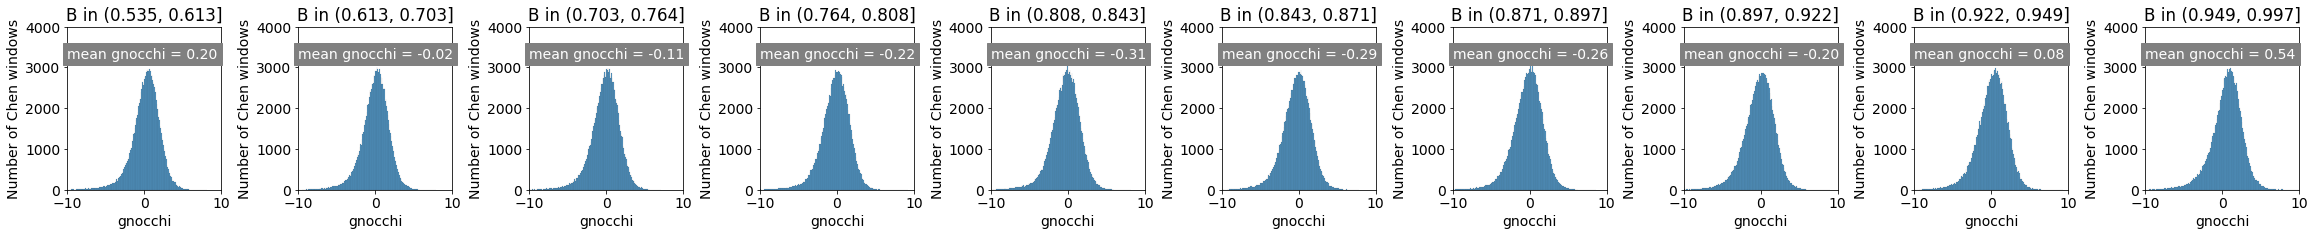

In [6]:
def plot_gnocchi_distribution(df, number_of_b_quantiles=10): 
  df = df.copy() 
  
  df['B_range'] = pd.qcut(df['B'], q=number_of_b_quantiles, labels=None, retbins=False)

  fig, axs = plt.subplots(1, number_of_b_quantiles, figsize=(40, 3))
  plt.subplots_adjust(wspace=0.5)
  for i, b_quantile in enumerate(sorted(df['B_range'].unique())): 
    df_b_range = df[df['B_range'] == b_quantile]
    sns.histplot(
      data=df_b_range, 
      x='gnocchi', 
      ax=axs[i],
    )
    axs[i].set_title(f'B in {b_quantile}')
    axs[i].set_xlim(-10, 10)
    axs[i].set_ylim(0, 4000)
    axs[i].set_ylabel('Number of Chen windows')
    mean_gnocchi = df_b_range['gnocchi'].mean()
    axs[i].text(-10, 3500, f'mean gnocchi = {mean_gnocchi:.2f}', ha='left', va='top', backgroundcolor='grey', color='white')

plot_gnocchi_distribution(WINDOWS)

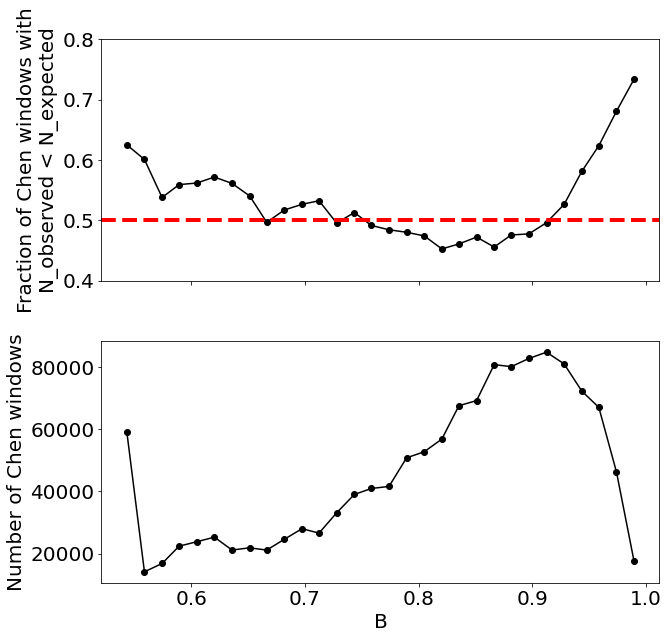

In [7]:
plt.rcParams.update({
  'font.size': 20,
})

def plot_fraction_below_diag(df, number_B_bins=30):  
  df = df.copy() 

  df['B_bin'] = pd.cut(df['B'], bins=number_B_bins)
  df['B_bin_mid'] = df['B_bin'].apply(lambda x: x.mid).astype(float)

  df['below_diag'] = df['N_observed'] < df['N_expected']

  df = aggregate(
    df, 
    group_columns = ['B_bin_mid'],
    aggregation_functions = {
      'below_diag': [np.mean],
      'B': ['count']
    }
  )
  df = df.rename(columns={
    'mean below_diag': 'fraction_below_diag',
  })
  
  fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
  fig.subplots_adjust(hspace=0.25)

  axs[0].plot(df['B_bin_mid'], df['fraction_below_diag'], 'o-', color='black')
  axs[0].axhline(y=0.5, color='red', linestyle='--', linewidth=4)
  axs[0].set_ylabel('Fraction of Chen windows with\nN_observed < N_expected')
  axs[0].set_ylim(0.4, 0.8)

  axs[1].plot(df['B_bin_mid'], df['count B'], 'o-', color='black')
  axs[1].set_ylabel('Number of Chen windows')

  axs[1].set_xlabel('B')

plot_fraction_below_diag(WINDOWS)  

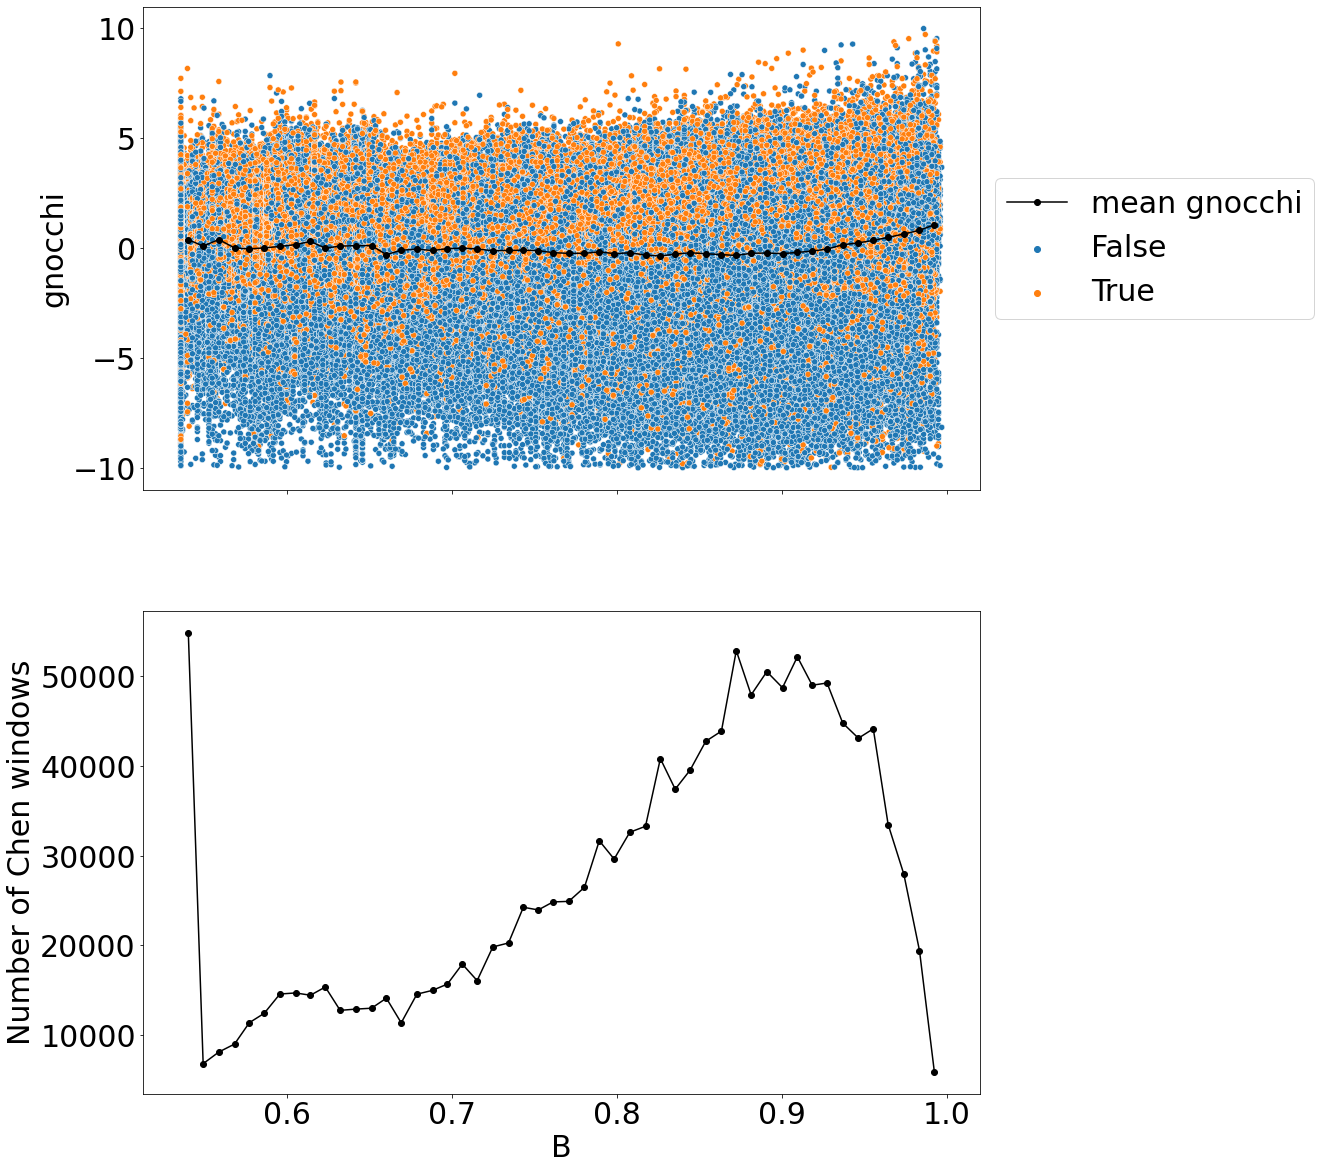

In [69]:
plt.rcParams.update({
  'font.size': 30,
})

def plot_mean_gnocchi(df, number_B_bins=50): 
  df = df.copy()

  df['B_bin'] = pd.cut(df['B'], bins=number_B_bins)
  df['B_bin_mid'] = df['B_bin'].apply(lambda x: x.mid).astype(float)
  df_aggregated = aggregate(
    df, 
    group_columns = ['B_bin_mid'],
    aggregation_functions = {
      'gnocchi': [np.mean],
      'B': ['count']
    }
  )

  fig, axs = plt.subplots(2, 1, figsize=(15, 20), sharex=True)
  fig.subplots_adjust(hspace=0.25)

  sns.scatterplot(
    data=df, 
    x='B', 
    y='gnocchi', 
    hue='window overlaps enhancer',
    ax=axs[0],
  )
  axs[0].plot(df_aggregated['B_bin_mid'], df_aggregated['mean gnocchi'], 'o-', color='black', label='mean gnocchi')
  axs[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

  axs[1].plot(df_aggregated['B_bin_mid'], df_aggregated['count B'], 'o-', color='black')
  axs[1].set_ylabel('Number of Chen windows')

  axs[1].set_xlabel('B')
  
plot_mean_gnocchi(WINDOWS)

## Compute and save naive BGS-corrected Gnocchi 

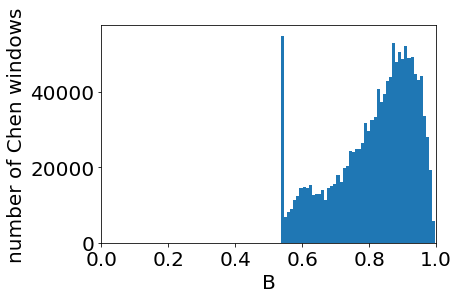

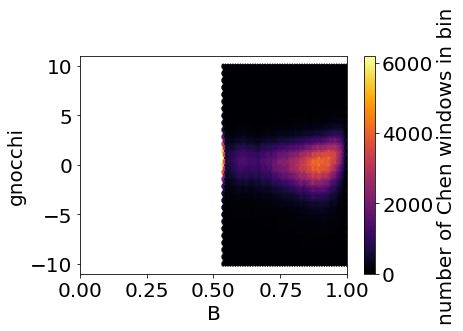

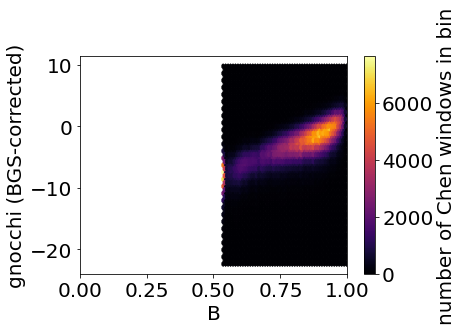

Wrote /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/chen-et-al-2023-published-version/41586_2023_6045_MOESM4_ESM/Supplementary_Data_2.gnocchi.bmap.gnocchi_BGS_corrected_naive.bed


In [9]:
def compute_BGS_corrected_gnocchi(df): 
  df = df.copy() 
  
  plt.hist(df['B'], bins=50)
  plt.xlabel('B')
  plt.ylabel('number of Chen windows')
  plt.xlim(0, 1)
  plt.show()

  plt.hexbin(df['B'], df['gnocchi'], gridsize=50, cmap='inferno')
  plt.colorbar(label='number of Chen windows in bin')
  plt.xlabel('B')
  plt.ylabel('gnocchi')
  plt.xlim(0, 1)
  plt.show() 

  df['N_expected_BGS_corrected'] = df['N_expected'] * df['B']
  df['gnocchi_BGS_corrected'] = (df['N_expected_BGS_corrected'] - df['N_observed']) / np.sqrt(df['N_expected_BGS_corrected'])

  plt.hexbin(df['B'], df['gnocchi_BGS_corrected'], gridsize=50, cmap='inferno')
  plt.colorbar(label='number of Chen windows in bin')
  plt.xlabel('B')
  plt.ylabel('gnocchi (BGS-corrected)')
  plt.xlim(0, 1)
  plt.show() 
  
  filename = f'{CONSTRAINT_TOOLS_DATA}/chen-et-al-2023-published-version/41586_2023_6045_MOESM4_ESM/Supplementary_Data_2.gnocchi.bmap.gnocchi_BGS_corrected_naive.bed'
  df.to_csv(
    filename,
    sep='\t',
    index=False,
  )
  print(f'Wrote {filename}')

compute_BGS_corrected_gnocchi(WINDOWS)

## For each B-stratum, correct Gnocchi by shifting N_expected so that it is lower than N_observed just as often as it is higher

In [10]:
def find_shift_value(pairs):
  n = len(pairs)
  left, right = 0, 100
  while right - left > 1:  
    mid = (left + right) / 2
    count_below_diag = sum(x - mid > y for x, y in pairs)
    if count_below_diag >= n / 2:
      left = mid
    else:
      right = mid
  return (left + right) / 2  

def correct_gnocchi(df): 
  pairs = [(x, y) for x, y in zip(df['N_expected'], df['N_observed'])]
  shift_value = find_shift_value(pairs)
  df['N_expected_BGS_corrected'] = df['N_expected'] - shift_value
  df['gnocchi_BGS_corrected'] = (df['N_expected_BGS_corrected'] - df['N_observed']) / np.sqrt(df['N_expected_BGS_corrected'])
  return df

def correct_gnocchi_by_bin(df, number_B_bins): 
  df = df.copy() 
  df['B_bin'] = pd.cut(df['B'], bins=number_B_bins)
  dfs = [correct_gnocchi(group) for _, group in df.groupby('B_bin')]
  return pd.concat(dfs)

correct_gnocchi_by_bin(WINDOWS, 10)

,chrom,start,end,gnocchi,N_expected,N_observed,window overlaps enhancer,window overlaps merged_exon,B,B_bin,N_expected_BGS_corrected,gnocchi_BGS_corrected
13232,chr1,26665000,26666000,0.738653,208.670152,198,False,False,0.582,"(0.536, 0.582]",202.810777,0.337808
13233,chr1,26668000,26669000,0.986173,186.466461,173,False,False,0.579,"(0.536, 0.582]",180.607086,0.566045
13234,chr1,26670000,26671000,2.610602,199.911299,163,False,False,0.576,"(0.536, 0.582]",194.051924,2.229100
13235,chr1,26672000,26673000,1.992740,218.453009,189,True,False,0.574,"(0.536, 0.582]",212.593634,1.618153
13236,chr1,26674000,26675000,2.080116,209.077458,179,False,False,0.572,"(0.536, 0.582]",203.218083,1.698864
...,...,...,...,...,...,...,...,...,...,...,...,...
1597029,chr9,136055000,136056000,4.940620,329.711581,240,True,False,0.953,"(0.951, 0.997]",319.164706,4.431229
1597030,chr9,136061000,136062000,3.950215,316.248127,246,False,False,0.960,"(0.951, 0.997]",305.701252,3.414561
1597031,chr9,136062000,136063000,2.456219,254.157846,215,False,False,0.960,"(0.951, 0.997]",243.610971,1.833092
1597032,chr9,136063000,136064000,1.805618,262.239857,233,False,False,0.960,"(0.951, 0.997]",251.692982,1.178265


## Gnocchi-based calls of constraint, but not enhancers, are enriched in regions with high B-values

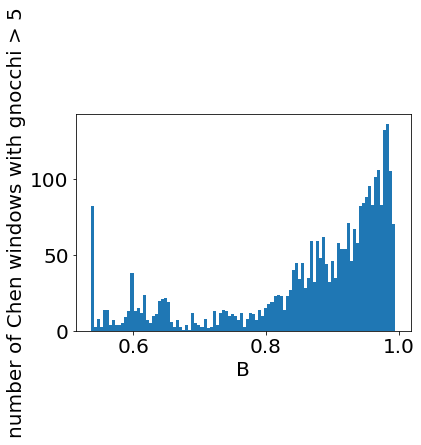

In [11]:
def plot_distribution_of_B_for_gnocchi_calls(df, gnocchi_threshold): 
  df = df.copy() 
  df = df[df['gnocchi'] > gnocchi_threshold]
  df.plot.hist(y='B', bins=100)
  plt.xlabel('B')
  plt.ylabel(f'number of Chen windows with gnocchi > {gnocchi_threshold}')
  plt.legend().remove()

plot_distribution_of_B_for_gnocchi_calls(WINDOWS, gnocchi_threshold=5) 

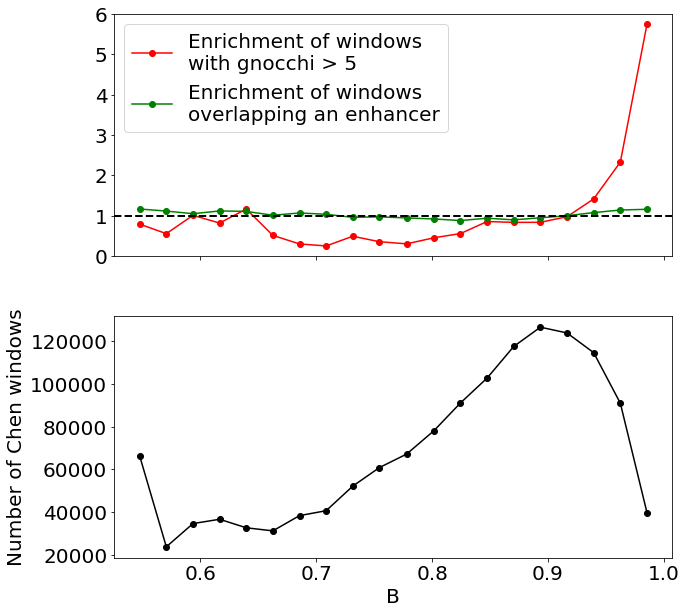

In [74]:
def plot_enrichment_of_windows(df, gnocchi_threshold, number_B_bins=20): 
  df = df.copy() 

  df['B_bin'] = pd.cut(df['B'], bins=number_B_bins)
  
  total_counts = df['B_bin'].value_counts().sort_index()
  total_frac = total_counts/total_counts.sum()

  gnocchi_counts = df[df['gnocchi'] > gnocchi_threshold]['B_bin'].value_counts().sort_index()
  gnocchi_frac = gnocchi_counts / gnocchi_counts.sum() 

  enhancer_counts = df[df['window overlaps enhancer'] == True]['B_bin'].value_counts().sort_index()
  enhancer_frac = enhancer_counts / enhancer_counts.sum() 

  gnocchi_enrichment = gnocchi_frac / total_frac
  enhancer_enrichment = enhancer_frac / total_frac
  
  total_counts.index = total_counts.index.map(lambda x: x.mid)
  gnocchi_enrichment.index = gnocchi_enrichment.index.map(lambda x: x.mid)
  enhancer_enrichment.index = enhancer_enrichment.index.map(lambda x: x.mid)

  plt.rcParams.update({'font.size': 20})

  fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
  fig.subplots_adjust(hspace=0.25)

  axs[0].plot(gnocchi_enrichment.index, gnocchi_enrichment, 'o-', color='red', label=f'Enrichment of windows\nwith gnocchi > {gnocchi_threshold}')
  axs[0].plot(enhancer_enrichment.index, enhancer_enrichment, 'o-', color='green', label=f'Enrichment of windows\noverlapping an enhancer')
  axs[0].axhline(y=1, color='black', linestyle='--', linewidth=2)
  axs[0].set_ylim(0, 6)
  axs[0].legend()

  axs[1].plot(total_counts.index, total_counts, 'o-', color='black')
  axs[1].set_ylabel('Number of Chen windows')
  axs[1].set_xlabel('B')

plot_enrichment_of_windows(WINDOWS, gnocchi_threshold=5)

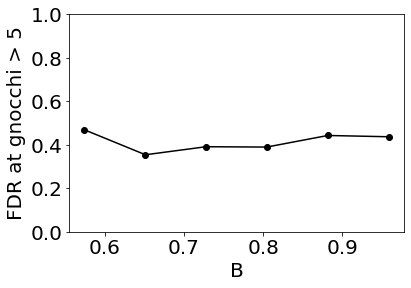

In [66]:
def plot_fdr(df, gnocchi_threshold, number_B_bins):
  df = df.copy()
  
  df['B_bin'] = pd.cut(df['B'], bins=number_B_bins)
  df['B_bin_mid'] = df['B_bin'].apply(lambda x: x.mid).astype(float)
  
  discoveries = df[df['gnocchi'] > gnocchi_threshold].groupby('B_bin_mid').size()
  false_discoveries = df[(df['gnocchi'] > gnocchi_threshold) & (df['window overlaps enhancer'] == False)].groupby('B_bin_mid').size()
  fdr = false_discoveries / discoveries  

  plt.plot(fdr.index, fdr, 'o-', color='black')
  plt.xlabel('B')
  plt.ylabel(f'FDR at gnocchi > {gnocchi_threshold}')
  plt.ylim(0, 1) 

plot_fdr(WINDOWS, gnocchi_threshold=5, number_B_bins=6)

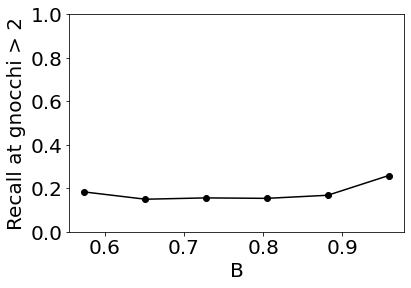

In [68]:
def plot_recall(df, gnocchi_threshold, number_B_bins):
  df = df.copy()
  
  df['B_bin'] = pd.cut(df['B'], bins=number_B_bins)
  df['B_bin_mid'] = df['B_bin'].apply(lambda x: x.mid).astype(float)
  
  events = df[df['window overlaps enhancer'] == True].groupby('B_bin_mid').size()
  called_events = df[(df['gnocchi'] > gnocchi_threshold) & (df['window overlaps enhancer'] == True)].groupby('B_bin_mid').size()  
  recall = called_events / events

  plt.plot(recall.index, recall, 'o-', color='black')
  plt.xlabel('B')
  plt.ylabel(f'Recall at gnocchi > {gnocchi_threshold}')
  plt.ylim(0, 1) 

plot_recall(WINDOWS, gnocchi_threshold=2, number_B_bins=6)